# Ejercicio 2: Face Detection

Tal como se explica en la letra del obligatorio final en este ejercicio es necesario implementar desde cero una solucion para detección de caras. Se proveen datos de entrenamiento y es necesario implementar su propio algoritmo de sliding window para entrenar un clasificador. Todo el código necesario para comenzar a trabajar está provisto en este notebook.


\**En los ejercicios del trabajo final es posible utilizar funciones de librerias existentes o código sacado de internet. Siempre y cuando **no se usen para resolver explicitamente lo que pide el ejercicio** y al código sacado de interenet le agreguen el link en comentarios de donde fue sacado ese código.*



##### Imports necesarios

In [1]:
%%script false --no-raise-error
import cv2 
import numpy as np
from glob import glob
from enum import Enum
import os
import sklearn 
import sklearn.neighbors
import matplotlib.pyplot as plt
import pickle
from evaluation import *
import sys
#from google.colab.patches import cv2_imshow
from image_utils import *
#from imutils.object_detection import non_max_suppression
import math

### Funciones Provistas



#### Feature Extractors 

Para resolver el ejercicio van a tener que implementar las funciones `extract_hog_features` y `extract_lbp_features`

In [2]:
%%script false --no-raise-error
class FeatureExtractors(Enum):
    MiniImage = 1
    HOG = 2
    LBP = 3

def extract_features(method, img):
    '''Switch between Feature extraction Methods'''

    image_representation = []

    if method == FeatureExtractors.MiniImage:
        image_representation = extract_mini_image_features(img)
    elif method == FeatureExtractors.HOG:
        image_representation = extract_hog_features(img)
    elif method == FeatureExtractors.LBP:
        image_representation = extract_lbp_features(img)

    return image_representation

def extract_mini_image_features(img,resize_size=(64,64)):
    resized_image = cv2.resize(img,resize_size)
    image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
    return image_representation


def extract_lbp_features(img):
    return []

def extract_hog_features(img):
    return []


   

#### Data loader

In [3]:
%%script false --no-raise-error
def load_training_data(training_positive_dir,training_negative_dir, feature_extractor=FeatureExtractors.MiniImage):
    ''' Function for loading loading training data from positive and negative examples
    '''
    positive_img_files = sorted(glob(training_positive_dir + '/*'))
    negative_img_files = sorted(glob(training_negative_dir + '/*'))
    #comment this line for loading all data
    positive_img_files = positive_img_files[:100]
    negative_img_files = negative_img_files[:200]

    training_data = []
    training_labels = []
    
    print('##Loading {} positive face images'.format(len(positive_img_files)))
    for img in positive_img_files:
        image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(1)
    
    print('##Loading {} negative face images'.format(len(negative_img_files)))
    for img in negative_img_files:
        image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(0)   
    
    training_data = np.asarray(training_data)
    training_labels = np.asarray(training_labels)
    return training_data, training_labels

def load_validation_data(validation_data_dir):

    validation_image_files = sorted(glob(validation_data_dir + '/*'))
    val_images = []
    for img_file in validation_image_files:
        image = cv2.imread(img_file,cv2.IMREAD_COLOR)
        val_images.append(image)

    return val_images 

#### Sliding Window


In [4]:
%%script false --no-raise-error
def sliding_window(image, window_size, scale, stride):
    [image_rows, image_cols] = image.shape;
    window_rows = window_size[0];
    window_cols = window_size[1];

    patches = np.zeros((window_rows, window_cols,5));
    bbox_locations = np.zeros((5,4))
    r = np.random.randint(0,image_rows-window_rows,5); # Sample top left position
    c = np.random.randint(0,image_cols-window_cols,5);
    for i in range(0,5):
        patches[:,:,i] = image[r[i]:r[i]+window_rows, c[i]:c[i]+window_cols];
        bbox_locations[i,:] = [r[i],c[i],window_rows,window_cols]; # top-left y,x, height, width


    return patches, bbox_locations

##### Metodos Auxiliares


In [5]:
%%script false --no-raise-error
def show_image_with_bbox(image,bboxes,draw_GT=True):
    GT = [82,91,166,175]
    if draw_GT:
        cv2.rectangle(image, (GT[0],GT[1]), (GT[2],GT[3]), (0, 0, 255), 2)

    for bbox in bboxes:
        if len(bbox) == 4:   
            top_left = (int(bbox[0]),int(bbox[1]))
            bottom_right = (int(bbox[0])+ int(bbox[2]),int(bbox[1])+int(bbox[3]))
            cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)
    plt.imshow(image[...,::-1])
    plt.axis('off')
    plt.show()
    #cv2.imshow('image',image)
    #cv2.waitKey(0) #wait for any key
    #cv2.destroyAllWindows()

### Ubicación de los datos ###

In [6]:
%%script false --no-raise-error
data_dir='./data'
face_detection_dir = os.path.join(data_dir, 'face_detection')
training_faces_dir = os.path.join(face_detection_dir,'cropped_faces')
negative_examples_training_dir = os.path.join(face_detection_dir,'non_faces_images','neg_cropped_img')
validation_faces_dir = os.path.join(face_detection_dir,'val_face_detection_images')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

## Entrenar Modelo y Face Detection


### Cargar Datos de Entrenamiento ###

In [7]:
%%script false --no-raise-error
#Modify data_loader.py to load more training data
training_data, training_labels = load_training_data(training_faces_dir,negative_examples_training_dir, FeatureExtractors.MiniImage)
# You can save traning_data and labels on numpy files to avoid processing data every time. 

### Load Validation Data ###

In [8]:
%%script false --no-raise-error
validation_data = load_validation_data(validation_faces_dir)

### Entrenar un clasificador utilizando los datos de entrenamiento ## 
1. Una vez los datos de entrenamiento han sido cargados es necesario entrenar su propio clasificador 
2. Como solución inicial se utiliza un clasificador KNN pero para tener mejores resultados es posible entrenar un SVM
3. Train your own classifier and save it on 'face_detector' file.Liblinear is suggested sample code for liblinear can be seen in './liblinear-2.30/python/README' file, good starting parameters for the classfier are '-s 2 -B 1'. 

In [9]:
%%script false --no-raise-error
knn_classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors=3)

In [10]:
%%script false --no-raise-error
knn_classifier.fit(training_data,training_labels)

#### Guardar el modelo entrenado ##

In [11]:
%%script false --no-raise-error
pickle.dump(knn_classifier,open('./face_detector_knn', 'wb'))

#### Cargar el Modelo entrenado 

In [12]:
%%script false --no-raise-error
classifier = pickle.load(open('./face_detector_knn','rb'))

### Do the sliding window and Visualize Results ###
1. In this part you need to perform the sliding window and score the probabilty of each patch of being a face and select the highest probability patches. 
    1a. Program you own sliding window in 'img_utils' file.
    1b. Extract Features and classify each patch with your own classifier. 
2. Do non-max suppression to select the target face patch with best probability (This is provided in 'img_utils')
3. Visualize Detection with Ground Throuth Bounding Box ('Code for Visualization is Provided')

In [13]:
%%script false --no-raise-error
window_size = [64, 64]
predictions = []
threshold_p = 0.5
overlap_threshold = 0.5
validation_data = load_validation_data(validation_faces_dir)
for img in validation_data:
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,1,32)

    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.MiniImage, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    ## Get prediction label for each sliding window patch
    labels = classifier.predict(patches_feature_representation)
    ## Get score for each sliding window patch
    scores = classifier.predict_proba(patches_feature_representation)
    ## Positive Face Probabilities
    face_probabilities = scores[:,1]
    face_bboxes = bbox_locations[face_probabilities>threshold_p]
    face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
    # Do non max suppression and select strongest probability box
    [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites)
    show_image_with_bbox(img, selected_bbox)


### Evaluate Detector ###

In [14]:
%%script false --no-raise-error
def evaluate_detector(bboxes, positive_probabilites):
    
    true_positives_number = np.zeros((100))
    actual_positives = np.zeros((100))
    predicted_positives = np.zeros((100))
    overlap_threshold = 0.5

    for i in np.arange(0,1,0.01):
        probability_threshold = i
        positive_bboxes = bboxes[positive_probabilites>=probability_threshold]
        positive_bboxes_prob = positive_probabilites[positive_probabilites>=probability_threshold]
        idx = int(np.round(i*100))
        if len(positive_bboxes) > 0:
            [selected_bboxes, selected_scores] = non_max_suppression(positive_bboxes, positive_bboxes_prob,0.3)
            ratio = []
            for selected_bbox in selected_bboxes:
                ratio.append(bb_intersection_over_union(selected_bbox, [82,91,84,84]));                                   
            
            ratio = np.asarray(ratio)
            positive_number = sum(ratio>=0.5); 
            
            true_positives_number[idx] = positive_number>=1;
            actual_positives[idx] = 1
            predicted_positives[idx] = len(ratio)

        else:
            true_positives_number[idx] = 0;
            actual_positives[idx] = 1
            predicted_positives[idx] = 0

    return [true_positives_number, actual_positives, predicted_positives]

In [15]:
%%script false --no-raise-error
total_true_positives = []
total_real_positives = []
total_true_prediction = []
window_size = [64, 64]
score_threshold = 0.5
sum_boxes=0
idx=0
for subject_folder in sorted(glob(validation_raw_faces_dir + '/*')):
    for img in sorted(glob(subject_folder + '/*.jpg')):
        idx+=1
        gray_image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        patches, bbox_locations = sliding_window(gray_image,window_size,1,32)
        ## You need to extract features for every patch (same features you used for training the classifier)
        patches_feature_representation = []
        for i in range(patches.shape[2]):
            patch_representation = extract_features(FeatureExtractors.MiniImage, patches[:,:,i])
            patches_feature_representation.append(patch_representation)
        patches_feature_representation = np.asarray(patches_feature_representation)
        ## Get score for each sliding window patch
        scores = classifier.predict_proba(patches_feature_representation)
        ## Positive Face Probabilities
        face_probabilities = scores[:,1]
        ## Filter boxes by probability or score KNN probability > 0.5 or SVM score > 0
        [ detected_true_positives, image_real_positives, detected_faces ] = evaluate_detector( bbox_locations, face_probabilities );
        
        total_true_positives.append(detected_true_positives)
        total_real_positives.append(image_real_positives)
        total_true_prediction.append(detected_faces)

total_true_positives = np.asarray(total_true_positives)
total_real_positives = np.asarray(total_real_positives)
total_true_prediction = np.asarray(total_true_prediction)


In [16]:
%%script false --no-raise-error
precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_true_prediction)

In [17]:
%%script false --no-raise-error
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)

In [18]:
%%script false --no-raise-error
ap = interpolated_average_precision(recall,precision)

In [19]:
%%script false --no-raise-error
print('Detection Average Precision is {}'.format(ap))

## Versión mejorada de todo

In [20]:
import cv2 
import numpy as np
from glob import glob
from enum import Enum
import os
import sklearn 
import sklearn.neighbors
import matplotlib.pyplot as plt
import pickle
from evaluation import *
import sys
#from google.colab.patches import cv2_imshow
from image_utils import *
#from imutils.object_detection import non_max_suppression
import math
from sklearn.svm import SVC

In [21]:
def show_image_with_bbox(image,bboxes,draw_GT=True):
    GT = [82,91,166,175]
    if draw_GT:
        cv2.rectangle(image, (GT[0],GT[1]), (GT[2],GT[3]), (0, 0, 255), 2)

    for bbox in bboxes:
        if len(bbox) == 4:   
            top_left = (int(bbox[0]),int(bbox[1]))
            bottom_right = (int(bbox[0])+ int(bbox[2]),int(bbox[1])+int(bbox[3]))
            cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)
    plt.imshow(image[...,::-1])
    plt.axis('off')
    plt.show()
    #cv2.imshow('image',image)
    #cv2.waitKey(0) #wait for any key
    #cv2.destroyAllWindows()

In [22]:
from skimage.feature import local_binary_pattern, hog

class FeatureExtractors(Enum):
    MiniImage = 1
    HOG = 2
    LBP = 3

def extract_features(method, img):
    '''Switch between Feature extraction Methods'''

    image_representation = []

    if method == FeatureExtractors.MiniImage:
        image_representation = extract_mini_image_features(img)
    elif method == FeatureExtractors.HOG:
        image_representation = extract_hog_features(img)
    elif method == FeatureExtractors.LBP:
        image_representation = extract_lbp_features(img)

    return image_representation

def extract_mini_image_features(img,resize_size=(64,64)):
    resized_image = cv2.resize(img,resize_size)
    image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
    return image_representation


def extract_lbp_features(img):
    # https://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=lbp#skimage.feature.local_binary_pattern
    # https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
    try:
        # settings for LBP
        radius = LBP_CONFIG['radius']
        n_points = LBP_CONFIG['n_points'] * LBP_CONFIG['radius']
        METHOD = LBP_CONFIG['METHOD']
    except NameError as e:
            radius, n_points, METHOD = 3, 8, 'uniform'
                    
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    
    width, height = lbp.shape
    
    CELL_SIZE = 16
    BINS = 10
    
    quantity_cells_w, quantity_cells_h = int(width/CELL_SIZE), int(height/CELL_SIZE)
    
    histograms = np.zeros((quantity_cells_w, quantity_cells_h, BINS))
    
    for i in range(0, quantity_cells_w):
        for j in range(0, quantity_cells_h):
            top_border, bottom_border = i*CELL_SIZE, (i+1)*CELL_SIZE
            left_border, right_border = j*CELL_SIZE, (j+1)*CELL_SIZE
            histogram, bins = np.histogram(lbp[top_border:bottom_border, left_border:right_border])
            histograms[i, j] = histogram
    
    sum_of_histograms = np.ravel(histograms).flatten()
    return sum_of_histograms

def extract_hog_features(img):
    # https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
    hog_repr = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(4, 4), feature_vector=True)
    return hog_repr


In [23]:
def load_training_data(training_positive_dir,training_negative_dir, feature_extractor=FeatureExtractors.MiniImage):
    ''' Function for loading loading training data from positive and negative examples
    '''
    positive_img_files = sorted(glob(training_positive_dir + '/*'))
    negative_img_files = sorted(glob(training_negative_dir + '/*'))
    
    #comment this line for loading all data
#     positive_img_files = positive_img_files[:100]
#     negative_img_files = negative_img_files[:200]

    training_data = []
    training_labels = []
    
    print('##Loading {} positive face images'.format(len(positive_img_files)))
    for img in positive_img_files:
        image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(1)
    
    print('##Loading {} negative face images'.format(len(negative_img_files)))
    for img in negative_img_files:
        image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(0)   
    
    training_data = np.asarray(training_data)
    training_labels = np.asarray(training_labels)
    return training_data, training_labels

def load_validation_data(validation_data_dir):

    validation_image_files = sorted(glob(validation_data_dir + '/*'))
    val_images = []
    for img_file in validation_image_files:
        image = cv2.imread(img_file,cv2.IMREAD_COLOR)
        val_images.append(image)

    return val_images 

In [24]:
def sliding_window(image, window_size, scale, stride):
    [image_rows, image_cols] = image.shape;
    window_rows = window_size[0];
    window_cols = window_size[1];
    '''
    # si es impar, xej largo 11, va de 0 a 10 y el centro es 5
    # ##si es par, xej largo 10, va de 0 a 9 y el centro es 4.5
    # divido entre dos y resto 0.5
    # o resto 1 y divido entre 2
    window_center = ((window_rows-1)/2, (window_cols-1)/2)
    
    half_row = 
    '''
    
    # Nah, es más fácil ir contando desde la esquina superior izquierda
    
    max_row_upper_left_pixel = image_rows-window_rows+1
    max_col_upper_left_pixel = image_cols-window_cols+1
    
    quantity_of_rowwise_boxes = math.ceil(max_row_upper_left_pixel/stride)
    quantity_of_colwise_boxes = math.ceil(max_col_upper_left_pixel/stride)
    
    patches = np.zeros((quantity_of_rowwise_boxes*quantity_of_colwise_boxes,window_rows,window_cols));
    

    bbox_locations = np.zeros((quantity_of_rowwise_boxes*quantity_of_colwise_boxes,4))
    
    for idx, i in enumerate(range(0, max_row_upper_left_pixel, stride)):
        for  jdx, j in enumerate(range(0, max_col_upper_left_pixel, stride)):
            # transformamos indice matricial idx, jdx a índice vectorial
            # idx, jdx => idx*width + jdx
            # https://stackoverflow.com/questions/14015556/how-to-map-the-indexes-of-a-matrix-to-a-1-dimensional-array-c
            # teníamos esto antes:
            # idx*jdx+jdx = (idx+1)*jdx
            # y no funcionaba del todo bien :)
            
            vdx = idx*quantity_of_rowwise_boxes+jdx
            patches[vdx] = image[i:i+window_rows, j:j+window_cols]
            bbox_locations[vdx] = [i, j, window_rows,window_cols] # top-left y,x, height, width]
            
    
    return patches, bbox_locations

In [25]:
data_dir='./data'
face_detection_dir = os.path.join(data_dir, 'face_detection')
training_faces_dir = os.path.join(face_detection_dir,'cropped_faces')
negative_examples_training_dir = os.path.join(face_detection_dir,'non_faces_images','neg_cropped_img')
validation_faces_dir = os.path.join(face_detection_dir,'val_face_detection_images')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

test_raw_faces_dir = os.path.join(face_detection_dir,'te_raw_images')

In [26]:
%%script false --no-raise-error
training_data, training_labels = load_training_data(training_faces_dir,negative_examples_training_dir, FeatureExtractors.LBP)

In [27]:
%%script false --no-raise-error
validation_data = load_validation_data(validation_faces_dir)

In [28]:
%%script false --no-raise-error
def train_SVM(C, kernel, x, y):
    svm = SVC(C=C, kernel=kernel, probability=True)
    svm.fit(x, y)
    return svm

# pickle.dump(svm,open(f'./svc-c.{C}-kernel.{chosen_kernel}', 'wb'))

In [29]:
%%script false --no-raise-error
window_size = [64, 64]
predictions = []
threshold_p = 0.5
overlap_threshold = 0.5


feature_extractor = FeatureExtractors.LBP

kernel = ['linear', 'poly', 'rbf', 'sigmoid']

C = 1

# training_data, training_labels = load_training_data(training_faces_dir,negative_examples_training_dir, feature_extractor)


print('b4 training')
svm = train_SVM(C, kernel[2], training_data, training_labels)
print('after training')

for i, img in enumerate(validation_data):
    print(i)
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,1,32)
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    
    for patch in patches:
        patch_histogram = extract_features(feature_extractor, patch)
        patches_feature_representation.append(patch_histogram)
    
    patches_feature_representation = np.asarray(patches_feature_representation)
    
    ## Get prediction label for each sliding window patch
    labels = svm.predict(patches_feature_representation)
    ## Get score for each sliding window patch
    scores = svm.predict_proba(patches_feature_representation)
    ## Positive Face Probabilities
    face_probabilities = scores[:,1]
    face_bboxes = bbox_locations[face_probabilities>threshold_p]
    face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
    # Do non max suppression and select strongest probability box
    [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites)
    show_image_with_bbox(img, selected_bbox)


In [30]:
def evaluate_detector(bboxes, positive_probabilites):
    
    true_positives_number = np.zeros((100))
    actual_positives = np.zeros((100))
    predicted_positives = np.zeros((100))
    overlap_threshold = 0.5

    for i in np.arange(0,1,0.01):
        probability_threshold = i
        positive_bboxes = bboxes[positive_probabilites>=probability_threshold]
        positive_bboxes_prob = positive_probabilites[positive_probabilites>=probability_threshold]
        idx = int(np.round(i*100))
        if len(positive_bboxes) > 0:
            [selected_bboxes, selected_scores] = non_max_suppression(positive_bboxes, positive_bboxes_prob,0.3)
            ratio = []
            for selected_bbox in selected_bboxes:
                ratio.append(bb_intersection_over_union(selected_bbox, [82,91,84,84]));                                   
            
            ratio = np.asarray(ratio)
            positive_number = sum(ratio>=0.5); 
            
            true_positives_number[idx] = positive_number>=1;
            actual_positives[idx] = 1
            predicted_positives[idx] = len(ratio)

        else:
            true_positives_number[idx] = 0;
            actual_positives[idx] = 1
            predicted_positives[idx] = 0

    return [true_positives_number, actual_positives, predicted_positives]

In [31]:
def get_ttpos_trpos_ttpred(folder, feature_extractor, classifier):
    
    total_true_positives = []
    total_real_positives = []
    total_true_prediction = []
    window_size = [64, 64]
    score_threshold = 0.5
    sum_boxes=0
    
    for subject_folder in sorted(glob(folder + '/*')):
        for img in sorted(glob(subject_folder + '/*.jpg')):
            
            gray_image = cv2.imread(img,cv2.IMREAD_GRAYSCALE)
            patches, bbox_locations = sliding_window(gray_image,window_size,1,32)
            ## You need to extract features for every patch (same features you used for training the classifier)
            patches_feature_representation = []

            for patch in patches:
                patch_histogram = extract_features(feature_extractor, patch)
                patches_feature_representation.append(patch_histogram)

            patches_feature_representation = np.asarray(patches_feature_representation)

            ## Get score for each sliding window patch
            scores = classifier.predict_proba(patches_feature_representation)
            ## Positive Face Probabilities
            face_probabilities = scores[:,1]
            ## Filter boxes by probability or score KNN probability > 0.5 or SVM score > 0
            [ detected_true_positives, image_real_positives, detected_faces ] = evaluate_detector( bbox_locations, face_probabilities );

            total_true_positives.append(detected_true_positives)
            total_real_positives.append(image_real_positives)
            total_true_prediction.append(detected_faces)

    total_true_positives = np.asarray(total_true_positives)
    total_real_positives = np.asarray(total_real_positives)
    total_true_prediction = np.asarray(total_true_prediction)

    return total_true_positives, total_real_positives,total_true_prediction

In [32]:
%%script false --no-raise-error
C = [0.01, 0.1, 0.5, 1, 2, 5]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

aps = []

feature_extractors = [
     FeatureExtractors.MiniImage,
     FeatureExtractors.LBP,
#      FeatureExtractors.HOG
][::-1]

for feature_extractor in feature_extractors:


    training_data, training_labels = load_training_data(training_faces_dir,negative_examples_training_dir, feature_extractor)


    for c in C:
        for k in kernel:

            folder = validation_raw_faces_dir

            print(f'started training C {c:3} kernel {k:8}, fe {feature_extractor}')
            classifier = train_SVM(c, k, training_data, training_labels)
            print('finished training')

            print('starting validation')
            total_true_positives, total_real_positives,total_true_prediction = get_ttpos_trpos_ttpred(folder, feature_extractor, classifier)
            print('ending validation')
            precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_true_prediction)

            plt.plot(recall, precision)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.xlim(0,1.1)
            plt.ylim(0,1.1)

            ap = interpolated_average_precision(recall,precision)
            print(f'\nC {float(c):3} kernel {k:8} - Detection Average Precision is {float(ap):12}')
            aps.append([ap, feature_extractor, c, k, classifier])
            
aps

In [33]:
%%script false --no-raise-error
pickle.dump(aps,open(f'./FINAL_HYPERPARAMETERS', 'wb'))

In [34]:
%%script false --no-raise-error
from operator import itemgetter

sorted(aps, key=itemgetter(0))

In [35]:
%%script false --no-raise-error
def train_SVM(C, kernel, x, y):
    svm = SVC(C=C, kernel=kernel, probability=True, degree=4, gamma=3)
    svm.fit(x, y)
    return svm


C = [5]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

aps = []

feature_extractors = [
     FeatureExtractors.MiniImage,
     FeatureExtractors.LBP,
     FeatureExtractors.HOG
][::-1]

for feature_extractor in feature_extractors:


    training_data, training_labels = load_training_data(training_faces_dir,negative_examples_training_dir, feature_extractor)


    for c in C:
        for k in kernel:

            folder = validation_raw_faces_dir

            print(f'started training C {c:3} kernel {k:8}, fe {feature_extractor}')
            classifier = train_SVM(c, k, training_data, training_labels)
            print('finished training')

            print('starting validation')
            total_true_positives, total_real_positives,total_true_prediction = get_ttpos_trpos_ttpred(folder, feature_extractor, classifier)
            print('ending validation')
            precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_true_prediction)

            plt.plot(recall, precision)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.xlim(0,1.1)
            plt.ylim(0,1.1)

            ap = interpolated_average_precision(recall,precision)
            print(f'\nC {float(c):3} kernel {k:8} - Detection Average Precision is {float(ap):12}')
            aps.append([ap, feature_extractor, c, k, classifier])
            
aps

In [36]:
%%script false --no-raise-error
def train_SVM(C, kernel, x, y):
    svm = SVC(C=C, kernel=kernel, probability=True, degree=4, gamma=3)
    svm.fit(x, y)
    return svm


C = [5]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

aps = []

feature_extractors = [
     FeatureExtractors.MiniImage,
     FeatureExtractors.LBP,
     FeatureExtractors.HOG
][::-1]

for feature_extractor in feature_extractors:


    training_data, training_labels = load_training_data(training_faces_dir,negative_examples_training_dir, feature_extractor)


    for c in C:
        for k in kernel:

            folder = validation_raw_faces_dir

            print(f'started training C {c:3} kernel {k:8}, fe {feature_extractor}')
            classifier = train_SVM(c, k, training_data, training_labels)
            print('finished training')

            print('starting validation')
            total_true_positives, total_real_positives,total_true_prediction = get_ttpos_trpos_ttpred(folder, feature_extractor, classifier)
            print('ending validation')
            precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_true_prediction)

            plt.plot(recall, precision)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.xlim(0,1.1)
            plt.ylim(0,1.1)

            ap = interpolated_average_precision(recall,precision)
            print(f'\nC {float(c):3} kernel {k:8} - Detection Average Precision is {float(ap):12}')
            aps.append([ap, feature_extractor, c, k, classifier])
            
aps

### Final Training

In [44]:
def train_SVM(C, kernel, x, y):
    svm = SVC(C=C, kernel=kernel, probability=True, degree=4, gamma=3)
    svm.fit(x, y)
    return svm

C = 5
kernel = 'poly'

feature_extractor = FeatureExtractors.HOG

training_data, training_labels = load_training_data(training_faces_dir,negative_examples_training_dir, feature_extractor)

print(f'started training C {C:3} kernel {kernel:8}, fe {feature_extractor}')
classifier = train_SVM(C, kernel, training_data, training_labels)
print('finished training')



##Loading 7308 positive face images
##Loading 4902 negative face images
started training C   5 kernel poly    , fe FeatureExtractors.HOG
finished training


### Final Validation

starting validation
ending validation

C 5.0 kernel poly     - Detection Average Precision is 0.7032850870060172


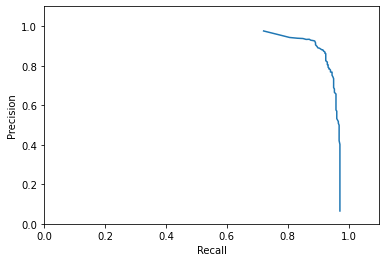

In [45]:


folder = validation_raw_faces_dir

print('starting validation')
total_true_positives, total_real_positives,total_true_prediction = get_ttpos_trpos_ttpred(folder, feature_extractor, classifier)
print('ending validation')
precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_true_prediction)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)

ap = interpolated_average_precision(recall,precision)
print(f'\nC {float(C):3} kernel {kernel:8} - Detection Average Precision is {float(ap):12}')

### Final Testing

starting testing
ending testing

C 5.0 kernel poly     - Detection Average Precision is 0.7378539493293593


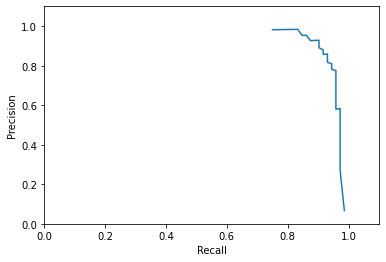

In [46]:

folder = test_raw_faces_dir

print('starting testing')
total_true_positives, total_real_positives,total_true_prediction = get_ttpos_trpos_ttpred(folder, feature_extractor, classifier)
print('ending testing')
precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_true_prediction)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)

ap = interpolated_average_precision(recall,precision)
print(f'\nC {float(C):3} kernel {kernel:8} - Detection Average Precision is {float(ap):12}')

### Demo

In [50]:
%%script false --no-raise-error
from PIL import Image

name = 'figurita.jpg'
image = Image.open(validation_faces_dir + '/' + name)
print(image.size)
resized_image = image.resize((250,250))
print(resized_image.size)
resized_image.save(validation_faces_dir + '/' + 'resized-' + name)

(606, 605)
(250, 250)


0


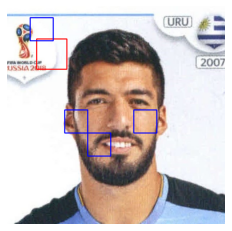

1


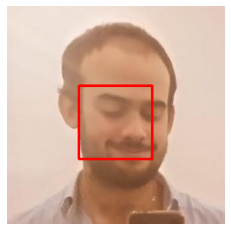

2


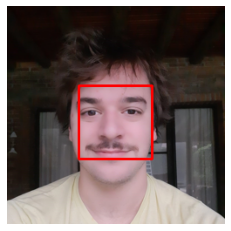

3


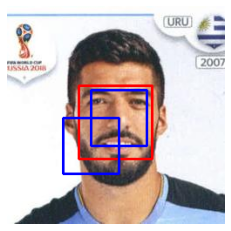

4


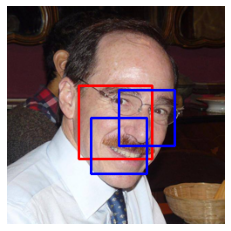

5


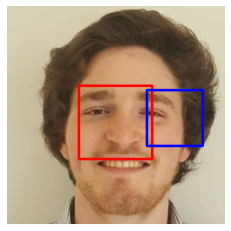

6


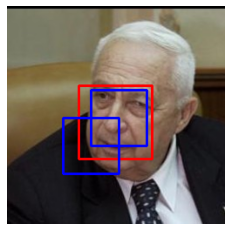

7


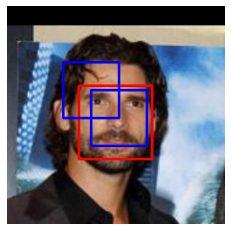

8


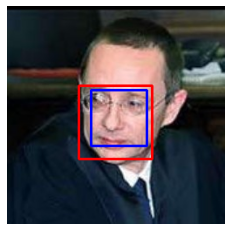

9


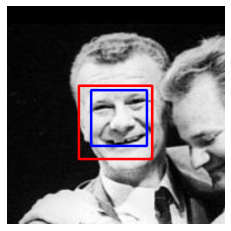

10


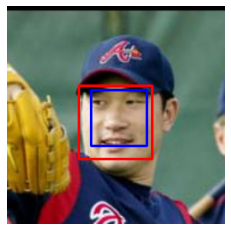

11


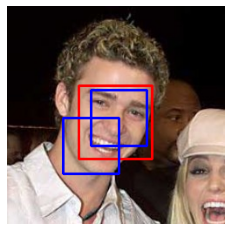

12


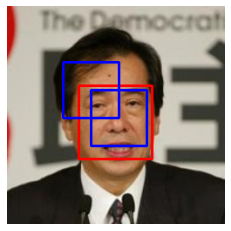

13


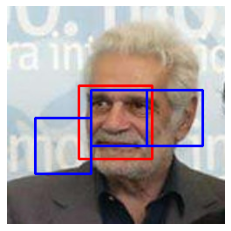

14


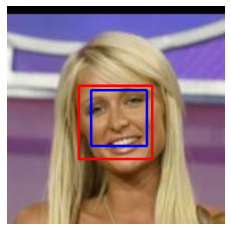

15


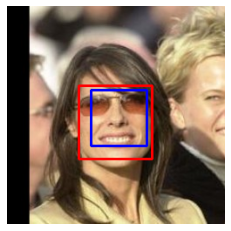

16


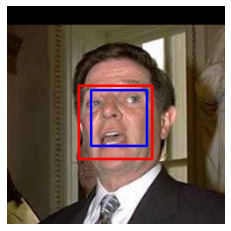

17


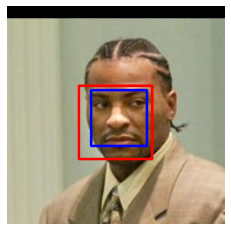

In [51]:
window_size = [64, 64]
predictions = []
threshold_p = 0.5
overlap_threshold = 0.5

validation_data = load_validation_data(validation_faces_dir)

for i, img in enumerate(validation_data):
    print(i)
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,1,32)
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    
    for patch in patches:
        patch_histogram = extract_features(feature_extractor, patch)
        patches_feature_representation.append(patch_histogram)
    
    patches_feature_representation = np.asarray(patches_feature_representation)
    
    ## Get prediction label for each sliding window patch
    labels = classifier.predict(patches_feature_representation)
    ## Get score for each sliding window patch
    scores = classifier.predict_proba(patches_feature_representation)
    ## Positive Face Probabilities
    face_probabilities = scores[:,1]
    face_bboxes = bbox_locations[face_probabilities>threshold_p]
    face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
    # Do non max suppression and select strongest probability box
    [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites)
    show_image_with_bbox(img, selected_bbox)
